# <b>Segmenting and Clustering Neighborhoods in Toronto</b>
<br>In this notebook I am working on the assignment for week 3 of the IBM's [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone) Course on Coursera. <br>
There are three major tasks to perform. <br>
In [Task 1](#Task-1---Generating-the-Data-Frame) Toronto neighborhood data is imported into a pandas data frame from a wikipedia.<br>
In [Task 2](#Task-2---Adding-Coordinates-to-Neighborhood-Data) we use geocoder to add geospacial coordinates to each neighborhood.<br>
In [Task 3](#Task-3---Exploring-and-Clustering-Neighborhoods-in-Toronto) we use Foursquare to explore the neighborhoods and cluster them according to some characteristics. 

## <b>Task 1 - Generating the Data Frame</b>

I am going to use the pandas to read the table into my dataframe. I looked up how to do it in this [video](https://www.youtube.com/watch?v=D8T1epVAx-4).

In [1]:
import numpy as np
import pandas as pd
wikitable = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
len(wikitable)

3

We see that there were actually 3 tables imported from the html. We can easily see that the first one is the one we want:

In [2]:
wikitable[0].head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
#create pandas data frame called df_postal. We only use the rows with actual Boroughs asigned to the postal code.
df_postal=wikitable[0][wikitable[0]['Borough']!='Not assigned']# we only use the rows which have assigned boroughs. Therefore we conditionally select the rows by using !='Not assigned'

In [4]:
df_postal.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Now that we deleted some rows, the index is not correct anymore. Therefore we want to reset it.

In [5]:
df_postal.reset_index(drop=True, inplace=True) #drop=True deletes the current index, False would leave it as a new row.
df_postal.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
df_postal.shape

(103, 3)

## <b>Task 2 - Adding Coordinates to Neighborhood Data<b>

In [7]:
import geocoder

As stated in the discussion [here](https://www.coursera.org/learn/applied-data-science-capstone/discussions/forums/R0oydmJfEeiMwRKU7H4Mng/threads/mPXvayChEeuDNgpyJIMFiQ), geocoder.google does not work. However geocoder.arcgis does.

In [ ]:
#we create two separate lists to store our Latitude an Longitude values.
Latitude=[] 
Longitude=[]
for i in range(len(df_postal)): #our dataframe consists of 103 rows. We iterate through all of them to geht our Postal Code.
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(df_postal.loc[i,'Postal Code']))
    lat_lng_coords = g.latlng
    Latitude.append(lat_lng_coords[0]) #and put the coordinates in lists.
    Longitude.append(lat_lng_coords[1])

In [9]:
#now we add the lists as columns to our dataframe
df_postal['Latitude']=Latitude
df_postal['Longitude']=Longitude
df_postal

<ipython-input-9-fc5a9cbd9abe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_postal['Latitude']=Latitude
<ipython-input-9-fc5a9cbd9abe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_postal['Longitude']=Longitude


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.65319,-79.51113
99,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.64869,-79.38544
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.63278,-79.48945


<b>Important Note</b>: ARCGIS gives slightly different coordinates than goolge. But they are in a walking distance, so they represent the same neighborhoods.

## <b>Task 3 - Exploring and Clustering Neighborhoods in Toronto</b>

First let's import all dependencies.

In [10]:
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

Let's use Foursquare. First our credientials, version and limit settings. To run, insert your own  CLIENT_ID and CLIENT_SECRET.

In [11]:
CLIENT_ID = 'YourID' 
CLIENT_SECRET = 'YOURSECRET'
VERSION = '20201212' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

We use the function provided in the [lab on clustering neighborhoods in New York](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/DS0701EN-3-3-2-Neighborhoods-New-York-py-v2.0.ipynb) to explore our neighborhoods. We want to extract the category of venues found in our neighborhoods.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we use the function getNearbyVenues() and put the results into the dataframe Toronto_venues.

In [13]:
Toronto_venues = getNearbyVenues(names=df_postal['Neighbourhood'],
                                   latitudes=df_postal['Latitude'],
                                   longitudes=df_postal['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

Let's see how many venues we found overall

In [14]:
Toronto_venues.shape

(2405, 7)

There are 2405 rows in the data frame, which means Foursquare found 2405 venues overall.

### Clustering Neighborhoods in all of Toronto

When we examine the venue categories, there is actually a category called "Neighborhood" - for example the venue "upper beaches" has the category "Neighborhood". I think this happens, because Forsquere treats whole interesting neighborhoods as venues. However we don't want that, so we drop all the rows which entail 'Neighborhood' in the 'Venue Category' column from Toronto_venues.

In [15]:
Toronto_venues= Toronto_venues.drop(Toronto_venues[Toronto_venues['Venue Category']=='Neighborhood'].index)
Toronto_venues.shape

(2399, 7)

We can see that 6 rows were dropped.

Let's create the dummy variables:

In [16]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
Toronto_onehot.shape

(2399, 270)

We can see that we have 269 different venue categories in our dataset. 270 columns including the Neighborhood.

We want each neighborhood to be one row, so we group them together and use the mean of each venue category as value for the category.

In [18]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Agincourt,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
2,Bayview Village,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
3,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
4,Berczy Park,0.0,0.0,0.0,0.016667,0.0,0.016667,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.016667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale West",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
92,Woburn,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
93,Woodbine Heights,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.055556,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
94,York Mills West,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0


The code below prints out the top 5 venue-categories for each neighborhood.

let's put them in a pandas data frame, so we can apply clustering later.

Again we take a function from the [New York lab](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/DS0701EN-3-3-2-Neighborhoods-New-York-py-v2.0.ipynb).

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [20]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Chinese Restaurant,Hong Kong Restaurant,Discount Store,Skating Rink,Shopping Mall
1,"Alderwood, Long Branch",Convenience Store,Pub,Performing Arts Venue,Gym,Field
2,Bayview Village,Construction & Landscaping,Golf Driving Range,Trail,Park,Ethiopian Restaurant
3,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Pub
4,Berczy Park,Coffee Shop,Cheese Shop,Cocktail Bar,Breakfast Spot,Beer Bar


Finally, the moment we have been waiting for. We can apply machine learning to <b>cluster our neighborhoods</b>!
<br>I will use all of Toronto for clustering. I want to try something that was not part of the labs. I want to use the elbow method as descibed in this [video](https://www.coursera.org/learn/machine-learning-with-python/lecture/rLcgP/more-on-k-means) to determine the number of clusters. So we are going to run the clustering algorithm multiple times and calculate the model accuracy each time. We are going to plot the accuracy levels against the number of clusters and finally look if there is an elbow point - the number of keys where the increase in the model accuracy does not increase much anymore.

In [34]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
# set number of clusters
inertia=[]
ks=[]
for k in range(1, 11): #we try 10 different values for k.
    # run k-means clustering
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 20)
    k_means.fit(Toronto_grouped_clustering)
    # determine the model-accuracy
    inertia.append( k_means.inertia_) #inertia is the Sum of squared distances of samples to their closest cluster center. We use this as a badness of fit meassure.
    ks.append(k)

Let's create a simple line plot to visualize inertia as dependent of k. Inertia is a value that tells us how close a point is to its centroid. That means we want our inertia to be as small as possible. However since inertia always decreases with higher ks we also don't want too many clusters.

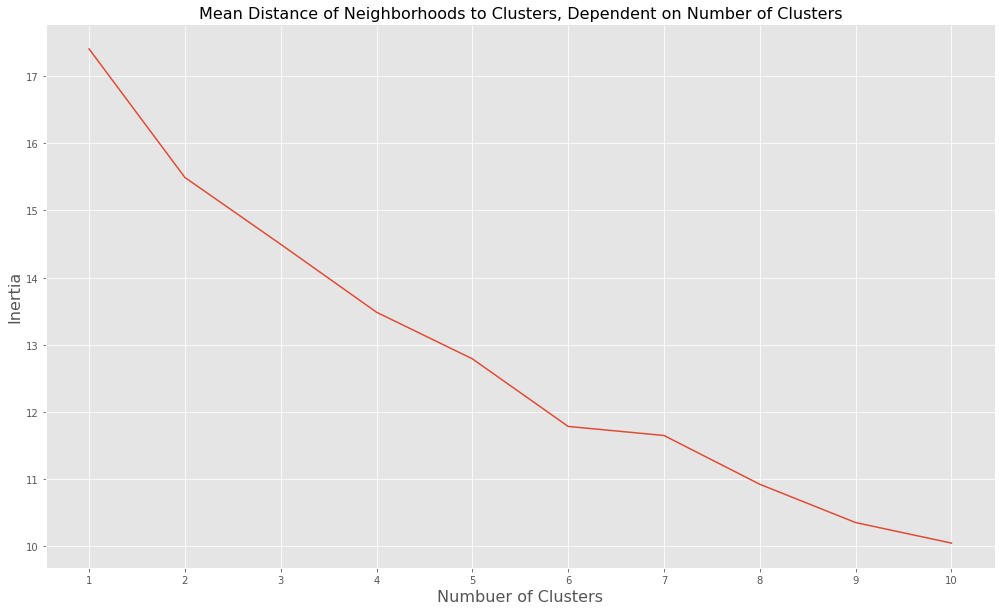

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 10))
plt.style.use('ggplot')
plt.plot(ks, inertia)
plt.xlabel('Numbuer of Clusters', size=16)
plt.ylabel('Inertia', size=16)
plt.title('Mean Distance of Neighborhoods to Clusters, Dependent on Number of Clusters', size=16)
plt.xticks(np.arange(min(ks), max(ks)+1, 1.0))
plt.show()

We can see that k=2 clusters reduce the inertia quite alot. Adding a third cluster only has half of the effect of the second cluster. Adding more clusters has the same effect. We will try clustering with only two clusters and then see what changes, when we increase the number of clusters later on. 

In [38]:
# Using k=2.
k=2
k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 20)
k_means.fit(Toronto_grouped_clustering)

KMeans(n_clusters=2, n_init=20)

In [40]:
# check cluster labels generated for each row in the dataframe
k_means.labels_[0:109] 

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0])

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_means.labels_)

df_postal.rename(columns={"Neighbourhood": "Neighborhood"},inplace=True) #We have different spellings of neighborhood, so we have to adjust.
Toronto_merged = df_postal

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the cloumn 'Cluster Labels'!

d:\python\lib\site-packages\pandas\core\frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,0.0,Food & Drink Shop,Park,Falafel Restaurant,Electronics Store,Elementary School
1,M4A,North York,Victoria Village,43.73057,-79.31306,0.0,Grocery Store,Park,Pharmacy,Zoo Exhibit,Electronics Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,1.0,Coffee Shop,Breakfast Spot,Pub,Electronics Store,Distribution Center
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,1.0,Clothing Store,Furniture / Home Store,Coffee Shop,Toy / Game Store,Women's Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,1.0,Coffee Shop,Sandwich Place,Burrito Place,Falafel Restaurant,Bank


In [42]:
Toronto_merged['Cluster Labels'].unique()

array([ 0.,  1., nan])

We can see that we have nan values. We will have to deal with them when we create the map. Look at the comments in the code below.

According to the New York lab, here the map of the clusters with folium

In [61]:
import math
# create map
Toronto_coord=geocoder.arcgis('Toronto, Canada').latlng
map_clusters = folium.Map(location=[Toronto_coord[0]+0.05,Toronto_coord[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
x=0
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    if math.isnan(cluster)==False: #as mentioned abvoe we have three missing values for Cluster. So we only create labels for those cases which do have a cluster label
         label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
         folium.CircleMarker(
             [lat, lon],
             radius=5,
             popup=label,
             color=rainbow[int(cluster)-1],
             fill=True,
             fill_color=rainbow[x-1],
             fill_opacity=0.7).add_to(map_clusters)
         x=x+1
map_clusters

IndexError: list index out of range

### Examine Clusters
When we simply look at the map we can see that there is a high density of purple neighborhoods in downtown Toronto. The red neighborhoods seem to be quite evenly distributed in the north and east. Let's check out what venues are typical for the clusters.

In [63]:
print('Neighborhoods in Cluster 0:', len(Toronto_merged[Toronto_merged['Cluster Labels']==0]))
print('Neighborhoods in Cluster 1:', len(Toronto_merged[Toronto_merged['Cluster Labels']==1]))

Neighborhoods in Cluster 0: 13
Neighborhoods in Cluster 1: 87


When we look at our map, we see that the puprple clusters, with high denisty in downtown are cluster 1, and the red ones are cluster 0.

In [46]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,0.0,Food & Drink Shop,Park,Falafel Restaurant,Electronics Store,Elementary School
1,North York,0.0,Grocery Store,Park,Pharmacy,Zoo Exhibit,Electronics Store
18,Scarborough,0.0,Construction & Landscaping,Park,Gym / Fitness Center,Fish Market,Fish & Chips Shop
22,Scarborough,0.0,Construction & Landscaping,Coffee Shop,Park,Business Service,Fish & Chips Shop
27,North York,0.0,Park,Residential Building (Apartment / Condo),Zoo Exhibit,Event Space,Eastern European Restaurant
35,East York,0.0,Convenience Store,Park,Intersection,Fish Market,Fish & Chips Shop
39,North York,0.0,Construction & Landscaping,Golf Driving Range,Trail,Park,Ethiopian Restaurant
45,North York,0.0,Park,Zoo Exhibit,Falafel Restaurant,Electronics Store,Elementary School
49,North York,0.0,Bakery,Park,Falafel Restaurant,Electronics Store,Elementary School
66,North York,0.0,Convenience Store,Speakeasy,Park,Falafel Restaurant,Electronics Store


We can see that cluster 1 consists of neighborhoods with many grocery stores, construction and landscaping values and parks.

In [64]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Downtown Toronto,1.0,Coffee Shop,Breakfast Spot,Pub,Electronics Store,Distribution Center
3,North York,1.0,Clothing Store,Furniture / Home Store,Coffee Shop,Toy / Game Store,Women's Store
4,Downtown Toronto,1.0,Coffee Shop,Sandwich Place,Burrito Place,Falafel Restaurant,Bank
5,Etobicoke,1.0,Pharmacy,Grocery Store,Café,Shopping Mall,Skating Rink
6,Scarborough,1.0,Zoo Exhibit,Fast Food Restaurant,Furniture / Home Store,Fish Market,Fish & Chips Shop
...,...,...,...,...,...,...,...
98,Etobicoke,1.0,Pool,Farm,Electronics Store,Elementary School,Escape Room
99,Downtown Toronto,1.0,Coffee Shop,Gay Bar,Japanese Restaurant,Restaurant,Sushi Restaurant
100,East Toronto,1.0,Coffee Shop,Hotel,Restaurant,Café,Bar
101,Etobicoke,1.0,Bank,Italian Restaurant,Chinese Restaurant,Flower Shop,Fast Food Restaurant


Compared to cluster 0, we see that cluster 1 consists of neighborhoods with many coffee shops, restaurants and a few other shops and markets.

It makes sense - since downtown Toronto is probably popular with tourists, while the neighborhoods in cluster 1 are probably more regions where families live, so they have many grocery stores and parks.

In [113]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,Etobicoke,2.0,Pool,Farm,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Food


### Adding a thrid cluster.

Let's see if we gain any useful information by adding a third cluster. We run the same code as above with an increased k.

In [67]:
# Using k=3.
k=3
k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 20)
k_means.fit(Toronto_grouped_clustering)

KMeans(n_clusters=3, n_init=20)

In [69]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']= k_means.labels_

df_postal.rename(columns={"Neighbourhood": "Neighborhood"},inplace=True) #We have different spellings of neighborhood, so we have to adjust.
Toronto_merged = df_postal

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the cloumn 'Cluster Labels'!

d:\python\lib\site-packages\pandas\core\frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,2.0,Food & Drink Shop,Park,Falafel Restaurant,Electronics Store,Elementary School
1,M4A,North York,Victoria Village,43.73057,-79.31306,2.0,Grocery Store,Park,Pharmacy,Zoo Exhibit,Electronics Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,1.0,Coffee Shop,Breakfast Spot,Pub,Electronics Store,Distribution Center
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,1.0,Clothing Store,Furniture / Home Store,Coffee Shop,Toy / Game Store,Women's Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,1.0,Coffee Shop,Sandwich Place,Burrito Place,Falafel Restaurant,Bank


In [70]:
#Let's see how many rows fall into each of the three categories:
print('Neighborhoods in Cluster 0:', len(Toronto_merged[Toronto_merged['Cluster Labels']==0]))
print('Neighborhoods in Cluster 1:', len(Toronto_merged[Toronto_merged['Cluster Labels']==1]))
print('Neighborhoods in Cluster 1:', len(Toronto_merged[Toronto_merged['Cluster Labels']==2]))

Neighborhoods in Cluster 0: 1
Neighborhoods in Cluster 1: 88
Neighborhoods in Cluster 1: 11


As we can see a new cluster was created, which only consists of 1 neighborhood. We can see that this does not help us very much, so we stop the analysis here.

### Conclusion
We found two clusters of neighborhoods in Toronto. Roughly we can sort them into neighborhoods with potentiality for going-out ,with many coffee shops and restaurants (high density in Downtown Toronto), and a second cluster of neighborhoods mostly for living, with grocery stores and parks. We can expect families to live there.